## Initial Calibration of EMIT L2A surface reflectance data against in-situ measurements 

Author: Willow Coleman

Date: 4/18/2023

In [2]:
# Import Packages
import os
from osgeo import gdal
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import geopandas as gp
import sys
sys.path.append('../modules/')
from emit_tools import emit_xarray
from geojson import Polygon, dump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy

### Open EMIT data file and clip to target ROI

In [4]:
# Key options: blackrock_playa, carson_valley, edward_creek, long_valley, smith_creek, amiaz_plain
key = 'amiaz_plain'

if key == 'blackrock_playa':
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220814T223520_2222615_004.nc'
    geo_path = '../data/coords/blackrock_playa_coords.geojson'
    insitu_path = '../20230410_EMIT_CalValKit/BlackRockPlayaZero/BlackRockPlaya_simple.txt'
    loc_name = 'Black Rock Playa'
elif key == 'carson_valley': 
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220814T223532_2222615_005.nc'
    insitu_path = '../20230410_EMIT_CalValKit/CarsonValley/northCarsonSinkPlaya_ASD_MERGEDsun+probe_measured17aug2022_rec3179_file_spd0716_simple.txt'
    geo_path = '../data/coords/carson_valley_coords.geojson'
    loc_name = 'Carson Valley'
elif key == 'edward_creek':
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220814T223544_2222615_006.nc'
    insitu_path = '../20230410_EMIT_CalValKit/EdwardCreek/EdwardCreekPlaya_EMITarea240x240m_ASDreflectanceCompositeSunAndProbeMerged__rec5701_file_spd0718_simple.txt'
    geo_path = '../data/coords/edward_creek_coords.geojson'
    loc_name = 'Edward Creek'
elif key == 'long_valley':
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220822T191949_2223413_005.nc'
    insitu_path = '../20230410_EMIT_CalValKit/LongValley/LongValleyPlaya_FullArea120x120m_ASDcomposite_MERGEDsun+probe_measured23aug2022_rec6290_file_spd0722_simple.txt'
    geo_path = '../data/coords/long_valley_coords.geojson'
    loc_name = 'Long Valley'
elif key == 'smith_creek': # May have cloud effects 
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220814T160552_2222611_008.nc'
    insitu_path = '../20230410_EMIT_CalValKit/SmithCreek/smithcreek_20220818.txt'
    geo_path = '../data/coords/smith_creek_coords.geojson'
    loc_name = 'Smith Creek'
elif key == 'amiaz_plain':
    emit_path = '../data/raw/EMIT_L2A_RFL_001_20220814T132215_2222609_004.nc'
    geo_path = '../data/coords/amiaz_plain_coords.geojson'
    loc_name = 'Amiaz Plain'

ds = emit_xarray(emit_path)
shape = gp.read_file(geo_path)
clipped = ds.rio.clip(shape.geometry.values,shape.crs, all_touched=True)

### Open in-situ data (ascii file or .xlsx)

In [5]:
if key == 'amiaz_plain':
    # insitu_path = pd.read_excel('../20230410_EMIT_CalValKit/AmiazPlain/EMIT_field/220822_AP_field.xlsx', sheet_name = "bare_fiber")
    insitu_path = pd.read_excel('../20230410_EMIT_CalValKit/AmiazPlain/EMIT_field/220822_AP_field.xlsx', sheet_name = "soil_pro")
    insitu = pd.DataFrame(
        {
        'insitu_wavelength': insitu_path['Unnamed: 0'],
        'insitu_reflectance': insitu_path['avg']
        }
    )
else: 
    with open(insitu_path) as fp:
        line = fp.readline()
        cnt = 1
        wavelength_list = []
        fwhm_list = []
        record_list = []
        for line in fp:
            line = line.strip()
            columns = line.split()
            wavelength = np.floor((float(columns[0]))*1000) # temp for matching (floor and conversion?)
            fwhm = (float(columns[1]))
            record = (float(columns[2]))
            wavelength_list.append(wavelength)
            fwhm_list.append(fwhm)
            record_list.append(record)

    # Convert to dataframe with 3 column variables
    insitu = pd.DataFrame(
        {'insitu_wavelength': wavelength_list,
        'insitu_FWHM': fwhm_list, 
        'insitu_reflectance': record_list
        })

### Compare SR and in-situ data

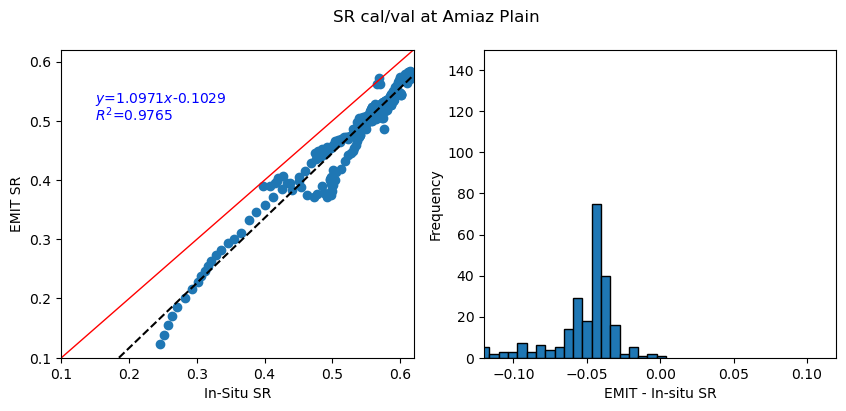

:Overlay
   .Curve.I  :Curve   [wavelengths]   (reflectance)
   .Curve.II :Curve   [insitu_wavelength]   (insitu_reflectance)

In [6]:
# Average clipped by band 
emit_avg = clipped.mean(dim = ["latitude", "longitude"]).to_dataframe()
emit_avg.wavelengths = np.floor(emit_avg.wavelengths)

# Join dataframe based on wavelength (nm)
merge = emit_avg.merge(insitu, left_on = 'wavelengths', right_on = 'insitu_wavelength')

# Remove any negative reflectance measurements
merge = merge[merge['reflectance'] > 0]
merge = merge[merge['insitu_reflectance'] > 0]

# Prepare for plotting
y = merge.reflectance
x = merge.insitu_reflectance

# Plot observed EMIT reflectance vs. in-situ surface reflectance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(x, y)
ax1.set(xlim = (0.1,0.62), ylim = (0.1,0.62), xlabel = 'In-Situ SR', ylabel = 'EMIT SR')
fig.suptitle('SR cal/val at ' + loc_name)

# Add y=x line
ax1.axline((0, 0), (1, 1), linewidth=1, color='r')

# Find line-of-best fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
ax1.axline((0, intercept), slope = slope, color = 'black', linestyle = 'dashed')
ax1.text(0.15, 0.5, '$R^2$=' + str(round(r_value,4)), color='blue')
ax1.text(0.15, 0.53, '$y$=' + str(round(slope,4)) + '$x$' + str(round(intercept,4)), color = 'blue')    

# Plot histogram of differences in reflectance
reflectance_diff = y-x 
ax2.hist(reflectance_diff, bins = 20, edgecolor = 'black')
ax2.set(xlim = (-0.12,0.12), ylim = (0,150), xlabel = 'EMIT - In-situ SR', ylabel = 'Frequency')
plt.show()

# Plot spectra
emit_avg.loc[:]['reflectance'][emit_avg.loc[:]['reflectance'] < 0 ] = np.nan
(emit_avg.hvplot(x='wavelengths',y='reflectance'))*insitu.hvplot(x='insitu_wavelength',y='insitu_reflectance').opts(xlabel='Wavelengths (nm)',ylabel='Reflectance', title='SR spectra at ' + loc_name)